In [1]:
!pip install h5py

In [2]:
# import NN necessities:
import torch
from torch import nn

# import plotting utilities:
import matplotlib.pyplot as plt

# import data preprocessing utilities:
from sklearn.model_selection import train_test_split
from pathlib import Path
import h5py
import numpy as np

In [3]:
class Network(nn.Module):   # class defining a basic nn

    def __init__(self, h_size=200):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(23, h_size),      # in
            nn.ReLU(),
            nn.Linear(h_size, h_size),    # hidden, 3 layers
            nn.ReLU(),
            nn.Linear(h_size, h_size),
            nn.ReLU(),
            nn.Linear(h_size, h_size),
            nn.ReLU(),
            # nn.Linear(h_size, 18)       # out
        )
        self.mean_head = nn.Linear(h_size, 18)
        self.logvar_head = nn.Linear(h_size, 18)

        # bind log-variance to avoid numerical instability
        self.max_logvar = nn.Parameter(torch.ones(18) * 0.5)
        self.min_logvar = nn.Parameter(torch.ones(18) * -10)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()    # using mean squared error as a loss metric

    def forward(self, x):
        res = self.model(x)
        mean = self.mean_head(res)
        logvar = self.logvar_head(res)

        # clamp log-variance using soft constraints (see MBPO/PETS)
        logvar = self.max_logvar - torch.nn.functional.softplus(self.max_logvar - logvar)
        logvar = self.min_logvar + torch.nn.functional.softplus(logvar - self.min_logvar)
        return mean, logvar

    def nll_loss(self, x, y):
        """
        Negative log-likelihood of Gaussian:
            NLL = 0.5 * [ logσ² + (y - µ)² / σ² ]
        """
        mean, logvar = self.forward(x)
        var = torch.exp(logvar)

        nll = 0.5 * ((y - mean)**2 / var + logvar)
        return nll.mean()

    def train_epoch(self, x, y):
        self.optimizer.zero_grad()

        loss = self.nll_loss(x, y)

        loss.backward()
        self.optimizer.step()
        return loss.item()


    def train(self, train_data, epochs=500, cp=100):
        x, y = train_data

        # again split the data to optimize hyperparam on val set, not leak data.
        x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True)
    
        test_losses = []
        losses = []
    
        for iter in range(epochs):
            # train
            iteration_loss = self.train_epoch(x_train, y_train)
            losses.append(iteration_loss)

            # validate
            val_loss = self.validation_loss((x_val, y_val))
            test_losses.append(val_loss)
    
            # print
            #if iter and iter % cp == 0:    # update on iteration checkpoints
                #print(f"iteration {iter}/{epochs}, loss = {iteration_loss}, {val_loss}")
        
        return losses, test_losses


    def validation_loss(self, test_data):
        x, y = test_data
        loss = self.nll_loss(x, y)
        return loss.item()


    def reset(self):
        self.__init__()

In [4]:
# load data
data = h5py.File(Path("./halfcheetah_medium-v2.hdf5"))
print(data.keys())


<KeysViewHDF5 ['actions', 'infos', 'metadata', 'next_observations', 'observations', 'rewards', 'terminals', 'timeouts']>


In [5]:
# extract relevant cols
a = data["actions"]
s_new = data["next_observations"]
s = data["observations"]
r = data["rewards"]

# info
print(
    f"a shape = {a.shape}\n" \
    f"s shape = {s.shape}\n" \
    f"s_new shape = {s_new.shape}\n" \
    f"r shape = {r.shape}\n"
)

a shape = (1000000, 6)
s shape = (1000000, 17)
s_new shape = (1000000, 17)
r shape = (1000000,)



In [6]:
# divide data
x = np.hstack([a, s])                                # -> (N, 23)
y = np.hstack([s_new, np.array(r).reshape(-1, 1)])   # -> (N, 18)

# converting to tensors
x = torch.tensor(x, dtype=torch.float32)   
y = torch.tensor(y, dtype=torch.float32)


In [7]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# your Network class exactly as you gave it above ...
# (no need to change it)

def validation_mse(model: Network, x_val: torch.Tensor, y_val: torch.Tensor, device) -> float:
    """Compute MSE on validation set using the mean head of the model."""
    with torch.no_grad():
        mean, _ = model.forward(x_val.to(device))
        mse = nn.MSELoss()(mean.to(device), y_val.to(device))
    return mse.item()

In [8]:
def run_size_sweep(x: torch.Tensor, y: torch.Tensor,
                   max_epochs: int = 100,
                   n_sizes: int = 20):
    """
    Train networks with different hidden sizes and record validation MSE curves.

    Returns
    -------
    hidden_sizes : list[int]
    val_mse_curves : np.ndarray of shape (n_sizes, max_epochs)
    """
    # split once so all models see the same train/val split
    x_train, x_val, y_train, y_val = train_test_split(
        x, y, test_size=0.2, shuffle=True
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"using device: {device}")
    
    x_train = x_train.to(device)
    x_test = x_val.to(device)
    y_train = y_train.to(device)
    y_test = y_val.to(device)

    # choose 20 hidden sizes, e.g. from 20 to 400
    hidden_sizes = np.linspace(20, 150, n_sizes, dtype=int)

    val_mse_curves = np.zeros((n_sizes, max_epochs))
    

    for i, h_size in enumerate(hidden_sizes):
        print(f"\n=== Training model with h_size = {h_size} ===")
        arr = [-1,-1,-1]
        for j in range(3):
            net = Network(h_size=h_size)
            net = net.to(device)

            net.train((x_train,y_train), epochs=max_epochs, cp=20)

                # compute validation MSE
            mse_val = validation_mse(net, x_val, y_val, device)
            arr[j] = mse_val
            
        val_mse_curves[i, max_epochs-1] = sum(arr)/3

    return hidden_sizes, val_mse_curves


In [9]:
hidden_sizes, val_mse_curves = run_size_sweep(x, y, max_epochs=1000, n_sizes=50)

final_mse = val_mse_curves[:, -1]  # MSE after last epoch



using device: cuda



=== Training model with h_size = 20 ===



=== Training model with h_size = 22 ===



=== Training model with h_size = 25 ===



=== Training model with h_size = 27 ===



=== Training model with h_size = 30 ===



=== Training model with h_size = 33 ===



=== Training model with h_size = 35 ===



=== Training model with h_size = 38 ===



=== Training model with h_size = 41 ===



=== Training model with h_size = 43 ===



=== Training model with h_size = 46 ===



=== Training model with h_size = 49 ===



=== Training model with h_size = 51 ===



=== Training model with h_size = 54 ===



=== Training model with h_size = 57 ===



=== Training model with h_size = 59 ===



=== Training model with h_size = 62 ===



=== Training model with h_size = 65 ===



=== Training model with h_size = 67 ===



=== Training model with h_size = 70 ===



=== Training model with h_size = 73 ===



=== Training model with h_size = 75 ===



=== Training model with h_size = 78 ===



=== Training model with h_size = 81 ===



=== Training model with h_size = 83 ===



=== Training model with h_size = 86 ===



=== Training model with h_size = 88 ===



=== Training model with h_size = 91 ===



=== Training model with h_size = 94 ===



=== Training model with h_size = 96 ===



=== Training model with h_size = 99 ===



=== Training model with h_size = 102 ===



=== Training model with h_size = 104 ===



=== Training model with h_size = 107 ===



=== Training model with h_size = 110 ===



=== Training model with h_size = 112 ===



=== Training model with h_size = 115 ===



=== Training model with h_size = 118 ===



=== Training model with h_size = 120 ===



=== Training model with h_size = 123 ===



=== Training model with h_size = 126 ===



=== Training model with h_size = 128 ===



=== Training model with h_size = 131 ===



=== Training model with h_size = 134 ===



=== Training model with h_size = 136 ===



=== Training model with h_size = 139 ===



=== Training model with h_size = 142 ===



=== Training model with h_size = 144 ===



=== Training model with h_size = 147 ===



=== Training model with h_size = 150 ===


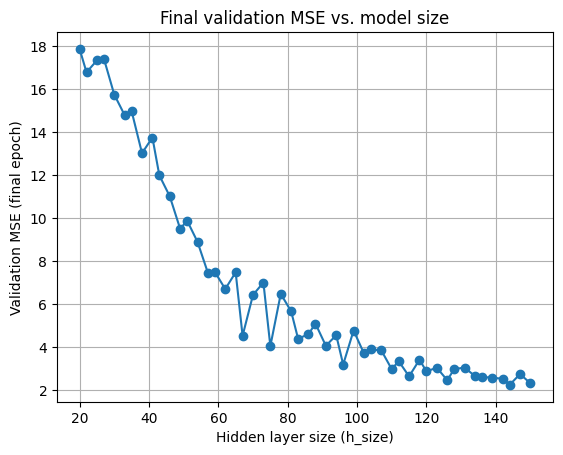

In [10]:
plt.figure()
plt.plot(hidden_sizes, final_mse, marker="o")
plt.xlabel("Hidden layer size (h_size)")
plt.ylabel("Validation MSE (final epoch)")
plt.title("Final validation MSE vs. model size")
plt.grid(True)
plt.show()

In [11]:
OUTDIR = Path(".")          # current directory = Mopo_test
OUTDIR.mkdir(exist_ok=True)

plt.savefig(OUTDIR / "loss_curve.png", dpi=200)
plt.close()